# Modelo de predicción de likes

In [1]:
import pandas as pd


from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('youtube-new/USvideos_last.csv')

Variables que no dependen de una estimación previa serán utilizadas para estimar el número de likes de un video.

Antes de proceder a eliminar estas columnas, usaremos un promedio agrupado por channel_title, category_id como base de likes, dislikes, views y comment_count.

In [3]:
# Promedio
df['mean_likes'] = df.groupby(['channel_title', 'category_id'])['likes'].transform('mean')
df['mean_dislikes'] = df.groupby(['channel_title', 'category_id'])['dislikes'].transform('mean')
df['mean_views'] = df.groupby(['channel_title', 'category_id'])['views'].transform('mean')
df['mean_comment_count'] = df.groupby(['channel_title', 'category_id'])['comment_count'].transform('mean')
# Variación, si es NA entonces se reemplaza por 0
df['std_likes'] = df.groupby(['channel_title', 'category_id'])['likes'].transform('std').fillna(0)
df['std_dislikes'] = df.groupby(['channel_title', 'category_id'])['dislikes'].transform('std').fillna(0)
df['std_views'] = df.groupby(['channel_title', 'category_id'])['views'].transform('std').fillna(0)
df['std_comment_count'] = df.groupby(['channel_title', 'category_id'])['comment_count'].transform('std').fillna(0)
# Mediana
df['median_likes'] = df.groupby(['channel_title', 'category_id'])['likes'].transform('median')
df['median_dislikes'] = df.groupby(['channel_title', 'category_id'])['dislikes'].transform('median')
df['median_views'] = df.groupby(['channel_title', 'category_id'])['views'].transform('median')
df['median_comment_count'] = df.groupby(['channel_title', 'category_id'])['comment_count'].transform('median')
# Mínimo
df['min_likes'] = df.groupby(['channel_title', 'category_id'])['likes'].transform('min')
df['min_dislikes'] = df.groupby(['channel_title', 'category_id'])['dislikes'].transform('min')
df['min_views'] = df.groupby(['channel_title', 'category_id'])['views'].transform('min')
df['min_comment_count'] = df.groupby(['channel_title', 'category_id'])['comment_count'].transform('min')
# Máximo
df['max_likes'] = df.groupby(['channel_title', 'category_id'])['likes'].transform('max')
df['max_dislikes'] = df.groupby(['channel_title', 'category_id'])['dislikes'].transform('max')
df['max_views'] = df.groupby(['channel_title', 'category_id'])['views'].transform('max')
df['max_comment_count'] = df.groupby(['channel_title', 'category_id'])['comment_count'].transform('max')

In [4]:
cols_to_exclude = ['trending_date', 'category_id', 'title', 'channel_title', 'publish_time', 'publish_time_', 'publish_date','tags', 'views', 'dislikes', 'comment_count', 
                   'thumbnail_link', 'video_error_or_removed', 'description', 'dislike_percentage', 'log_views', 'log_likes',
                   'log_dislikes', 'log_comment_count', 'ratio_likes', 'ratio_dislikes', 'ratio_comments', 'ratio_likes_dislikes', 
                   'ratio_likes_comments', 'ratio_dislikes_comments', 'ratio_likes_dislikes_comments', 'ratio_likes_dislikes_views', 
                   'ratio_likes_comments_views', 'ratio_dislikes_comments_views', 'ratio_likes_dislikes_comments_views', 'time_to_trend']

df_model = df.copy().drop(cols_to_exclude, axis=1)

Creamos un diccionario para codificar las variables categóricas category_name y publish_day.

In [5]:
# Assigning to unique values to each category
category_name = df_model['category_name'].unique()
category_name_dict = dict(zip(category_name, range(len(category_name))))
df_model['category_name'] = df_model['category_name'].map(category_name_dict)

publish_day = df_model['publish_day'].unique()
publish_day_dict = dict(zip(publish_day, range(len(publish_day))))
df_model['publish_day'] = df_model['publish_day'].map(publish_day_dict)

In [6]:
df_model.head()

,video_id,likes,comments_disabled,ratings_disabled,category_name,publish_hour,publish_day,publish_month,count_word,count_word_tags,...,median_views,median_comment_count,min_likes,min_dislikes,min_views,min_comment_count,max_likes,max_dislikes,max_views,max_comment_count
0,-0CMnp02rNY,9773,False,False,0,13,0,6,11,39,...,883050.0,694.5,1950,23,94139,0,282075,10433,10523399,21655
1,-0NYY8cqdiQ,4429,False,False,0,14,0,1,10,16,...,883050.0,694.5,1950,23,94139,0,282075,10433,10523399,21655
2,-1Hm41N0dUs,41248,False,False,1,7,1,4,8,19,...,1476212.5,1696.0,1245,177,83425,218,215764,18649,8751813,33795
3,-1yT-K3c6YI,7734,False,False,2,18,2,11,10,7,...,155301.5,886.5,2732,94,51141,256,24977,212,369565,3109
4,-2RVw2_QyxQ,460,False,False,3,2,3,11,5,2,...,82160.0,118.0,460,27,71089,20,902,73,152916,141


# Modelado

Usaremos un modelo e xgboost para predecir el número de likes de un video. Luego de entrenar el modelo, se evaluará su desempeño y la importancia de las variables. Basándonos en sus resultados iniciales, se decidirá si se requiere un tuneo de hiperparámetros y usar otros modelos.

In [7]:
# División de datos:
# Dividiremos los datos en tres conjuntos: entrenamiento, validación y prueba (70%, 15%, 15%)

X = df_model.drop('likes', axis=1).set_index('video_id')
y = df_model['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Entrenamiento

Entrenaremos el modelo con los datos de entrenamiento usando un evallist para evaluar el desempeño del modelo en los datos de validación. Luego de entrenar el modelo, se evaluará su desempeño en los datos de prueba.

In [8]:
# Configuración del modelo
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,  # early stopping como parámetro del modelo
    eval_metric='rmse'
)


In [9]:

# Entrenamiento
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Para ver el mejor número de iteraciones
print(f"Mejor iteración: {model.best_iteration}")

[0]	validation_0-rmse:237572.09767
[1]	validation_0-rmse:233909.58571
[2]	validation_0-rmse:230491.32266
[3]	validation_0-rmse:227387.61416
[4]	validation_0-rmse:224486.50984
[5]	validation_0-rmse:220238.34621
[6]	validation_0-rmse:216075.58383
[7]	validation_0-rmse:212395.94167
[8]	validation_0-rmse:208987.13140
[9]	validation_0-rmse:205876.40329
[10]	validation_0-rmse:202960.90774
[11]	validation_0-rmse:201271.21688
[12]	validation_0-rmse:197235.24342
[13]	validation_0-rmse:195014.57426
[14]	validation_0-rmse:191427.12064
[15]	validation_0-rmse:189989.18351
[16]	validation_0-rmse:186755.59050
[17]	validation_0-rmse:185608.12603
[18]	validation_0-rmse:182756.10528
[19]	validation_0-rmse:181669.24776
[20]	validation_0-rmse:180640.35488
[21]	validation_0-rmse:179476.97800
[22]	validation_0-rmse:176624.30535
[23]	validation_0-rmse:174054.29991
[24]	validation_0-rmse:171716.25569
[25]	validation_0-rmse:169595.31897
[26]	validation_0-rmse:167414.42141
[27]	validation_0-rmse:165644.39523
[2

In [10]:
# Evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")

MAE: 33206.485059516
R2: 0.5352905988693237


## Importancia de las variables


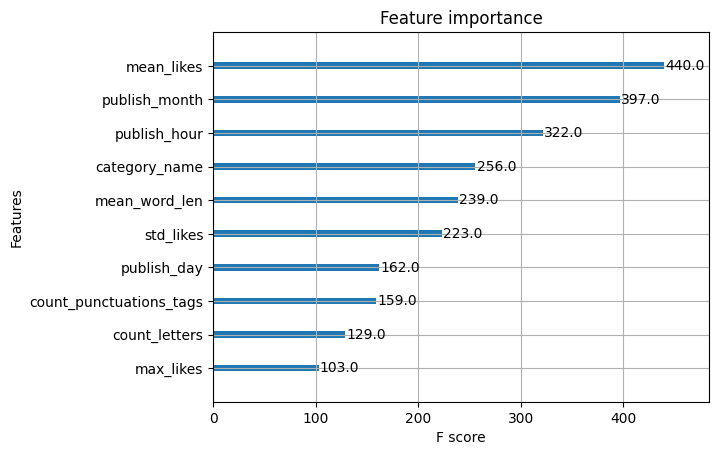

In [11]:
# Importancia de las variables (Top 10)
xgb.plot_importance(model, max_num_features=10)
plt.show()

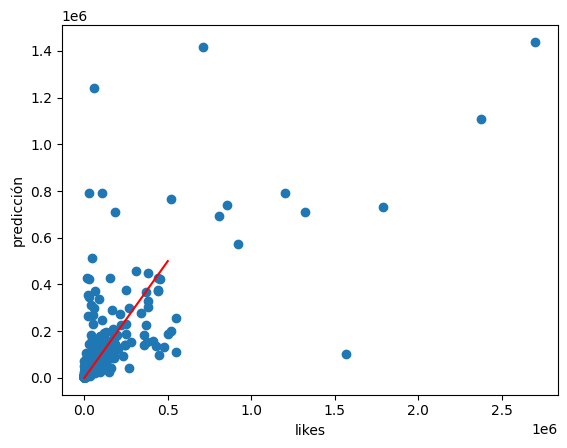

In [12]:
# Scatter plot de likes vs predicción Add line
plt.scatter(y_test, y_pred)
plt.plot([0, 500000], [0, 500000], color='red')
plt.xlabel('likes')
plt.ylabel('predicción')
plt.show()

Evaluación de métricas quitando atípicos.

In [13]:
# Quitar atípicos
outliers = (y_test - y_pred).abs() > 100000
y_test_no_outliers = y_test[~outliers]
y_pred_no_outliers = y_pred[~outliers]

mae_no_outliers = mean_absolute_error(y_test_no_outliers, y_pred_no_outliers)
r2_no_outliers = r2_score(y_test_no_outliers, y_pred_no_outliers)

print(f"MAE sin atípicos: {mae_no_outliers}")
print(f"R2 sin atípicos: {r2_no_outliers}")

MAE sin atípicos: 12864.540584500419
R2 sin atípicos: 0.8641403913497925


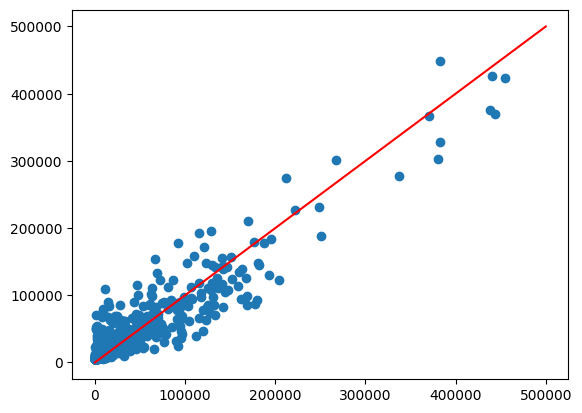

In [14]:
# Scatter plot de likes vs predicción sin atípicos
plt.scatter(y_test_no_outliers, y_pred_no_outliers)
plt.plot([0, 500000], [0, 500000], color='red')
plt.show()


Guardamos el modelo para su uso posterior.

In [15]:
model.save_model('models/model_likes_xgboost.json')

In [16]:
# Ejecutamos un pip freeze para guardar los paquetes utilizados
!pip freeze > requirements.txt